# Swift UVOT Events

## Reading in Data

In [2]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import Angle, SkyCoord
from astropy.stats import sigma_clipped_stats
from astropy.timeseries import TimeSeries
from astropy.timeseries import BinnedTimeSeries
from astropy.timeseries import aggregate_downsample
from astropy import units as u
from astropy.time import Time
from astropy.time import TimeGPS

from regions import CircleSkyRegion
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
import wget

In [4]:
## Run this to download the files locally.

eventDataUrl = 'https://www.swift.ac.uk/archive/reproc/00094137009/uvot/event/sw00094137009um2w1po_uf.evt.gz'
imgDataUrl = 'https://www.swift.ac.uk/archive/reproc/00094137009/uvot/products/sw00094137009u_sk.img.gz'

eventPath = 'sw00094137009um2w1po_uf.evt.gz'
imgPath = 'sw00094137009u_sk.img.gz'

try:
    wget.download(eventDataUrl, eventPath)
    wget.download(imgDataUrl, imgPath)
    print('Downloaded files')
    
except:
    print('Error downloading files')

  4% [..                                                  ]  3940352 / 79529450Error downloading files


In [3]:
## Open files after downloading them locally. No need to change the file path.

eventFile = fits.open('sw00094137009um2w1po_uf.evt.gz')
imgFile = fits.open('sw00094137009u_sk.img.gz')

primaryHdu = imgFile[0]
imgHdu = imgFile[1]

wcs = WCS(imgHdu.header)

events = eventFile[1].data

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 59236.264051 from DATE-OBS.
Set MJD-END to 59236.548553 from DATE-END'. [astropy.wcs.wcs]


In [4]:
print(events)

[(6.32983520e+08,   1867,   1370, 1916, 1439, 2238, 1547, 1,   0)
 (6.32983520e+08,   1534,   1402, 1593, 1476, 2137, 1857, 1,   0)
 (6.32983520e+08,   2039,   1420, 2079, 1486, 2348, 1419, 1,   0) ...
 (6.33013801e+08,   1164,   1636, 1229, 1718, 2616, 2093, 6, 256)
 (6.33013801e+08,    347,   1727,  432, 1810, 2294, 2827, 6, 256)
 (6.33013801e+08,   1453,   1997, 1503, 2069, 3058, 2034, 6, 256)]


In [5]:
print(wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 116.110733 3.551811 
CRPIX : 1604.5 1583.5 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.000139444442 0.000139444442 
NAXIS : 3208  3166


## Cleaning Event Data

In [6]:
events_good = events[np.where((events.QUALITY == 0))]
## quality flag of 0 = good
print(f'removed {len(events) - len(events_good)} events')

removed 1952995 events


In [113]:
## Removing non-continuous data points (or floating chunks of data)

events_good.sort()
events_int = [tuple(events_good[0])]
waiting_interval = []

formats = events_good.dtype

eStart = events_good['TIME'][0]
eLast = events_good['TIME'][0]

for i in range(1, len(events_good)):
    eTime = events_good['TIME'][i]
    if (eTime - eLast < 2):
        # print('flag')
        waiting_interval.append(tuple(events_good[i]))
        eLast = eTime
    else:
        # print('flag 2')
        ## end the interval
        if (eTime - eStart > 80): ## interval is large
            events_int += waiting_interval
        waiting_interval = []
        eStart = events_good['TIME'][i + 1]
        eLast = events_good['TIME'][i + 1]
            
events_clean = np.array(events_int, dtype=formats)

In [116]:
events_clean = events_clean.view(np.recarray)
len(events_clean)

2982463

## Displaying Event Data

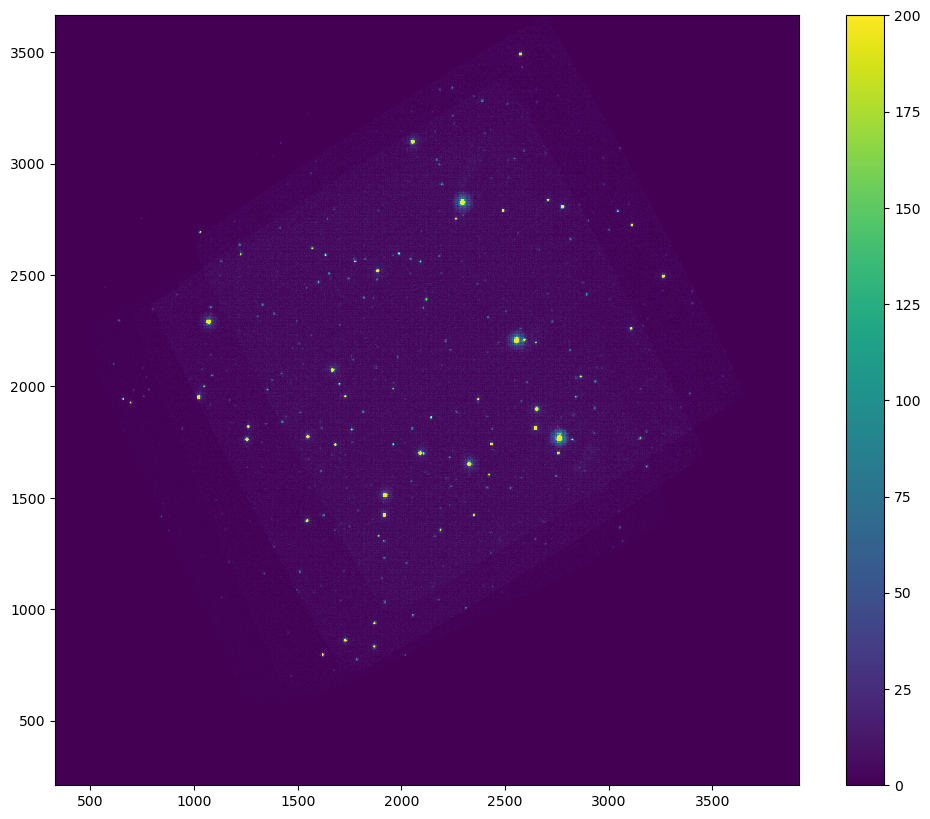

In [117]:
fig, ax = plt.subplots(figsize=(12, 10))

#plt.subplot(projection=wcs)

histdata, x_bins, y_bins, img = plt.hist2d(events_clean.X, events_clean.Y, bins=1000, vmin=0, vmax=200)
plt.colorbar()
plt.show()

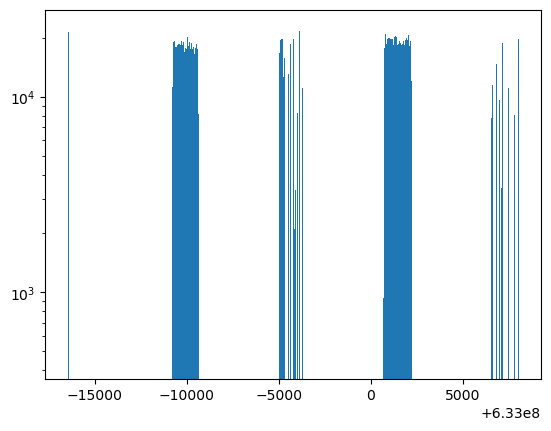

In [272]:
times = plt.hist(events_clean['TIME'], bins=1000, log=True)
plt.show()

## Star-finding

In [119]:
## import annulus
from PIL import Image
im_frame = Image.open('annuli_imgs/annulus_22.png')
## these stars are smaller, so we use the smaller annulus

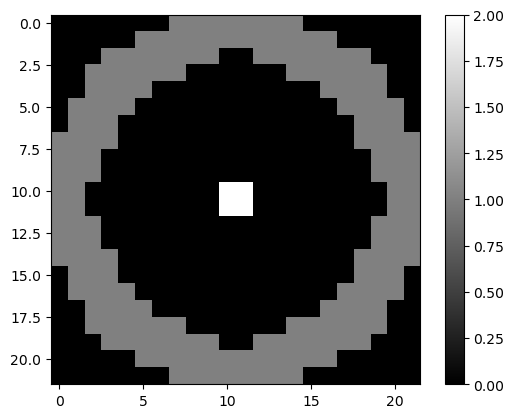

In [120]:
np_frame = np.array(im_frame)
annulus_size = len(np_frame)

## fix up imported annulus
annulus = np.zeros((annulus_size, annulus_size))
for i in range(annulus_size):
    for j in range(annulus_size):
        if (np_frame[i, j, 0] == 0 and np_frame[i, j, 3] == 255):
            annulus[i, j] = 1 ## background
        elif (np_frame[i, j, 0] == 112):
            annulus[i, j] = 2 ## star (circle aperture)
            
plt.imshow(annulus, cmap='gray')
plt.colorbar()
plt.show()

### Signal to Noise Ratio

In [121]:
## signal-to-noise ratio function from counting_stars_v5

def calculate_ratio (testImg, x, y):
    ## Summing counts

    circle_counts = 0
    annulus_counts = 0
    
    circle_pixels = 0
    annulus_pixels = 0

    for i in range(annulus_size):
        for j in range(annulus_size):
            try:
                if (annulus[i, j] == 2):
                    circle_counts += testImg[i + x, j + y]
                    circle_pixels += 1
                elif (annulus[i, j] == 1):
                    annulus_counts += testImg[i + x, j + y]
                    annulus_pixels += 1
            except:
                pass
                
    # Sky background per Pixel (N_s)
    sky_bg_pixel = annulus_counts / annulus_pixels

    # Signal in Aperture (N_T)
    signal = (circle_counts - (circle_pixels * annulus_counts / annulus_pixels))
    
    # Total noise = sqrt(N_T + N_s * npix + other stuff (dark current, readout))
    total_noise = np.sqrt(signal + (circle_pixels * annulus_counts / annulus_pixels))
    
    if (total_noise == 0):
        total_noise = 0.01
    
    return signal/total_noise

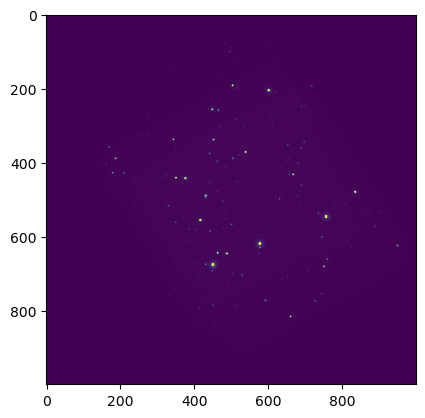

In [122]:
testImg = histdata
plt.imshow(testImg, vmin=0, vmax=500)
plt.show()

In [123]:
snrImg = np.zeros(testImg.shape)
offset = int((annulus_size + 1)/2)
for i in range(-offset, len(testImg) - offset):
    for j in range(-offset, len(testImg[0]) - offset):
        snrImg[i + offset, j + offset] = calculate_ratio(testImg, i, j)

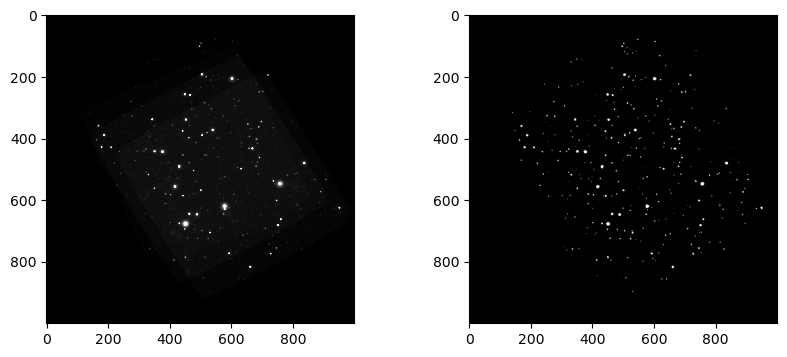

In [124]:
threshold = 5

## apply threshold on testImg
imgCut = np.zeros(snrImg.shape)

for i in range(len(snrImg)):
    for j in range(len(snrImg[0])):
        if (snrImg[i, j] >= threshold):
            imgCut[i, j] = 100
        else:
            imgCut[i, j] = 0

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axes[0].imshow(testImg, cmap='gray', vmin=0, vmax=100)
axes[1].imshow(imgCut, cmap='gray')
plt.show()

### Counting the Stars

In [125]:
def hasNeighborAbove (matrix, i, j):
    try:
        if (matrix[i - 1][j - 2] or
            matrix[i - 1][j - 1] or
            matrix[i - 1][j] or
            matrix[i - 1][j + 1] or
            matrix[i - 1][j + 2] or
            matrix[i][j - 1]):
            return 0
        else:
            return 1
    except:
        return -1

In [126]:
matrix = [[False for i in range(len(testImg[0]))] for j in range(len(testImg))]

count = 0

for i in range(len(imgCut)):
    for j in range(len(imgCut[0])):
        if (imgCut[i, j] == 100):
            matrix[i][j] = True
            if (hasNeighborAbove(matrix, i, j) == 1):
                count += 1
        else:
            matrix[i][j] = False

In [127]:
print('number of stars:', count)

number of stars: 349


## Star Data
Access stars by coordinates, SNR ratio, and display them by index.

In [128]:
class StarData:
    stars = []
    coords = []
    SNRs = []
    
    def __init__ (self, stars):
        self.stars = stars
        self.coords = [[] for _ in range(len(stars))]
        self.SNRs = [0 for _ in range(len(stars))]
        
        for i in range(len(self.stars)):
            xmin, xmax = 1000, 0
            ymin, ymax = 1000, 0
            snrCount = 0
            for [x, y] in self.stars[i]:
                snrCount += snrImg[x, y]
                if (x > xmax): 
                    xmax = x
                elif (x < xmin):
                    xmin = x
                if (y > ymax):
                    ymax = y
                elif (y < ymin):
                    ymin = y
            starX = int((xmax + xmin)/2)
            starY = int((ymin + ymax)/2)
            
            self.coords[i] = [starX, starY]
            
            self.SNRs[i] = snrCount/len(self.stars[i])
                     
    def getStarByCoord (self, x, y, window=100):
        for i in range(len(self.coords)):
            if (x - window <= self.coords[i][0] <= x + window):
                if (y - window <= self.coords[i][1] <= y + window):
                    print('star', i, 'at', self.coords[i], 'with snr', self.SNRs[i])
                     
    def getStarBySnr (self, minSNR, maxSNR=400):
        for i in range(len(self.SNRs)):
            if (minSNR <= self.SNRs[i] <= maxSNR):
                print('star', i, 'at', self.coords[i], 'with snr', self.SNRs[i])
                
    def displayStar (self, i, size=15, mode='zoom'): ## mode='whole' shows star in context of whole image
        x, y = self.coords[i]
        print(x, y)
        if (mode == 'zoom'):
            plt.imshow(testImg[x - size:x + size, y - size:y + size], vmin=0, vmax=200, cmap='gray')
        else:
            starCircle = plt.Circle((y, x), size, color='y', fill=False)
            plt.imshow(testImg, vmin=0, vmax=200, cmap='gray')
            plt.gca().add_patch(starCircle)
        plt.show()

## Finding the Changing Event

1) Isolate all the coordinates of individual stars.

2) For each star:
    
    a) Get the star data
    
    b) For each possible size of a signal window:
        
        i) For each possible window in the star data:
        
            Calculate the SNR ratio
            
        ii) Return all timestamps with an outlier SNR ratio
        
    c) Return all signal windows with outlier timestamps

### Isolating Stars
Code and helper function to get a list of all the stars, and index contains a list of the coordinates of the star.

In [129]:
def getStar (matrix, i, j):
    ## initial star has coords (i, j)
    star = []
    queue = [[i, j]]
    visited = []
    
    ## floodfill to get the rest of the star
    while (queue != []):
        n1, n2 = queue.pop(0)
        if (matrix[n1][n2] and [n1, n2] not in visited):
            star.append([n1, n2])
            if (n1 > 0 and [n1 - 1, n2] not in visited):
                queue.append([n1 - 1, n2])
            if (n1 < len(matrix) - 2 and [n1 + 1, n2] not in visited):
                queue.append([n1 + 1, n2])
            if (n2 > 0 and [n1, n2 - 1] not in visited):
                queue.append([n1, n2 - 1])
            if (n2 < len(matrix[0]) - 2 and [n1, n2 + 1] not in visited):
                queue.append([n1, n2 + 1])
        
        visited.append([n1, n2])
        
    return [star, visited]

In [130]:
stars = []
visited = []
for i in range(1, len(matrix)):
    for j in range(1, len(matrix[0])):
        if (matrix[i][j] and [i, j] not in visited):
            [star, v] = getStar(matrix, i, j)
            stars.append(star)
            visited += v

In [131]:
starList = StarData(stars)

### Getting Data for a Star
Gets event data for a star based on its coordinates.

In [132]:
def getData (star):
    starData = []
    for [s1, s2] in star:
        mask1 = events_clean['X'] >= x_bins[s1]
        filter1 = events_clean[mask1]
        mask2 = filter1['X'] < x_bins[s1 + 1]
        filter2 = filter1[mask2]
        mask3 = filter2['Y'] >= y_bins[s2]
        filter3 = filter2[mask3]
        mask4 = filter3['Y'] < y_bins[s2 + 1]
        filter4 = filter3[mask4]
        
        starData.append(np.array(filter4))
        
    return np.array([d for ls in starData for d in ls])

### Other Helper Functions

In [133]:
## Visualize the events of a given star
def visualizeStarTS (starData, binsize=5, xmin=632980000, xmax=633020000, windowStart=-1, windowSize=-1, customLim=False, point=False):
    end = Time(max(starData['TIME']), format='gps').fits
    timeBounds = []
    
    if (not customLim and windowStart != -1 and windowSize != -1):
        bgWindow = 1.5 * windowSize
        windowDist = 0.2 * windowSize
        xmin = windowStart - windowDist - bgWindow - 0.25 * windowSize
        xmax = windowStart + windowSize + windowDist + bgWindow + 0.25 * windowSize
        
    for i in range(len(starData['TIME'])):
        if (xmin <= starData['TIME'][i] <= xmax):
            timeBounds.append(starData['TIME'][i])
    
    times = [Time(t, format='gps') for t in timeBounds]
    
    ts = TimeSeries(time=times)
    
    ts['num_events'] = [1 for _ in range(len(ts))]
    
    binnedts = aggregate_downsample(ts, time_bin_size=binsize * u.second, aggregate_func=np.sum)
    
    if (point):
        plt.plot(binnedts.time_bin_start.gps, binnedts['num_events'], 'b.')
    else:
        plt.plot(binnedts.time_bin_start.gps, binnedts['num_events'], 'b-')
    plt.xlim(xmin, xmax)
    plt.ylim(0, max(binnedts['num_events']) + 1)
    
    if (windowStart != -1 and windowSize != -1):
        bgWindow = 1.5 * windowSize
        windowDist = 0.2 * windowSize
        
        plt.axvspan(windowStart, windowStart + windowSize, color='g', alpha=0.5, lw=0)
        
        plt.axvspan(windowStart - windowDist - bgWindow, windowStart - windowDist, color='r', alpha=0.5, lw=0)
        plt.axvspan(windowStart + windowSize + windowDist, windowStart + windowSize + windowDist + bgWindow, 
                    color='r', alpha=0.5, lw=0)
        
    plt.show()
    
    ts.time.format = 'gps'
    binnedts.time_bin_start.format = 'gps'
    return binnedts

In [336]:
## Split mass of data into contiguous intervals.
def splitInterval (starData, windowLength=5):
    starData.sort()
    intervals = []
    interval = [starData[0]]
    for i in range(1, len(starData)):
        if (starData[i] - starData[i - 1] > windowLength):
            if (len(interval) > 0):
                dist = max(interval) - min(interval)
                if (dist >= windowLength * 4 and len(interval) > windowLength * 4):
                    intervals.append(np.array(interval))
            interval = [starData[i]]
        else:
            interval.append(starData[i])
    
    return intervals

### Calculating SNR Ratio
Input: window size, beginning of signal window timestamp, sorted star data

Output: signal to noise ratio

Guaranteed: beginning of signal window timestamp is inside the sorted star data

In [286]:
def calculateRatio (signalWindow, timeStart, starData, printLog=False):
    ## calculate background window size
    bgWindow = 1.5 * signalWindow ## 1.5 times the length of the signal window on both sides
    windowDist = 0.2 * signalWindow ## distance between bgWindow and signalWindow
    bgArea = 0
    
    ## adding up photon counts
    # signal
    sigLeftMask = starData >= timeStart
    sigRight = starData[sigLeftMask]
    sigRightMask = sigRight <= timeStart + signalWindow
    sig = sigRight[sigRightMask]
    
    signalCounts = len(sig)
    if (signalCounts == 0):
        return 0
    
    # background
    leftBgLeftMask = starData >= timeStart - bgWindow - windowDist
    leftBgLeft = starData[leftBgLeftMask]
    leftBgRightMask = leftBgLeft <= timeStart - windowDist
    leftBg = leftBgLeft[leftBgRightMask]
    
    rightBgLeftMask = starData >= timeStart + signalWindow + windowDist
    rightBgLeft = starData[rightBgLeftMask]
    rightBgRightMask = rightBgLeft <= timeStart + signalWindow + bgWindow + windowDist
    rightBg = rightBgLeft[rightBgRightMask]
    
    bgCounts = len(leftBg) + len(rightBg)
    bgRaw = np.append(leftBg, rightBg)
    
    ## area of bg window
    leftBound = timeStart - bgWindow - windowDist
    rightBound = timeStart + signalWindow + bgWindow + windowDist
    
    if (leftBound < min(starData)):
        bgArea += timeStart - windowDist - min(starData)
    elif (len(leftBg) == 0):
        bgArea += 0
    else:
        bgArea += bgWindow
    
    if (max(starData) < rightBound):
        bgArea += max(starData) - timeStart - signalWindow - windowDist 
    elif (len(rightBg) == 0):
        bgArea += 0
    else:
        bgArea += bgWindow  
    
    if (bgArea == 0):
        return 0
    
    np.divide(bgRaw, np.array([max(bgArea, 1) for _ in range(len(bgRaw))]))
    
    ## we are guaranteed signal window is within the data, so signalArea = signalWindow
    
    ## calculating noise
    bgMean = bgCounts/bgArea
    signal = signalCounts/signalWindow - bgMean
    totalNoise = np.std(bgRaw)**2
    
    if (printLog):
        print('signalCounts', signalCounts, 'signalArea', signalWindow)
        print('bgCounts', bgCounts, 'bgArea', bgArea)
        print('bgMean', bgMean, 'signal', signal, 'totalNoise', totalNoise)
        print('snr', signal/totalNoise)
    
    ## catch divide-by-0 error (preventative)
    if (totalNoise <= 0):
        totalNoise = 0.01
        
    return signal/totalNoise

### Finding Interesting Signals for Each Star
Input: signal window, sorted star event data

Output: list of S/N ratios, measured timestamps

Outlier threshold: mean + 4 * SD

In [136]:
def gaussian (x, a, mean, sigma):
    return a * np.exp(-((x-mean)**2)/(2*sigma**2))

In [137]:
def getSignals (signalWindow, starData, printLog=False):
    ratios = []
    measuredTimestamps = []
    
    intervals = splitInterval(starData, signalWindow)
    
    for i in intervals:
        i.sort()
        start = int(min(i))
        end = int(max(i) - signalWindow)
        for s in range(start, end, int(0.25 * signalWindow)):
            ratios.append(calculateRatio(signalWindow, s, i, printLog))
            if (ratios[-1] > 10):
                print(ratios[-1], s, i)
            measuredTimestamps.append(s)
    
    return ratios, measuredTimestamps

In [138]:
def visualizeSignals (ratios, numBins):
    ratio_n, ratio_bins, _ = plt.hist(ratios, bins=numBins, log=True)
    x = np.linspace(min(ratios), max(ratios), numBins)
    y = ratio_n

    try:
        popt, pcov = curve_fit(gaussian, x, y)
        plt.plot(x, gaussian(x, *popt), c='r')

        plt.axis([min(ratios) - 1, max(ratios) + 1, 0.5, 5000])

        ## fit parameters

        amp, mean, stdev = popt
        print('amp', amp, 'mean', mean, 'stdev', stdev)

        plt.axvline(x=threshold, c='g', linewidth=1)
        
    except:
        mean = np.mean(ratios)
        stdev = np.std(ratios)
        
    threshold = mean + 5 * stdev
    
    plt.show()
    
    return mean, stdev, threshold

In [139]:
def getOutlierTimestamps (ratios, measuredTimestamps, threshold=5):
    outlierTimestamps = []
    for i in range(len(ratios)):
        if (ratios[i] > threshold):
            outlierTimestamps.append(measuredTimestamps[i])
            
    return outlierTimestamps

In [140]:
def unusualSignalInfo (ratios, measuredTimes, ratioEstimate, left=False):
    for i in range(len(ratios)):
        if (not left and ratios[i] > ratioEstimate):
            print('index', i, 'with ratio', ratios[i], 'at time', measuredTimes[i])
        if (left and ratios[i] < ratioEstimate):
            print('index', i, 'with ratio', ratios[i], 'at time', measuredTimes[i])

### Iterating over Signal Window Size
Iterates over different signal window sizes for a given star.

Input: star data

Output: dictionary of outlier timestamps for each signal window

In [141]:
def analyzeStar (starData):
    sortedStarData = np.array(sorted(starData))
    outlierWindows = {}
    
    minWindow = 5
    maxWindow = 30
    
    for i in range(minWindow, maxWindow):
        print('window', i)
        ratios, measuredTimestamps = getSignals(i, sortedStarData)
        mean, stdev, threshold = visualizeSignals(ratios, 100)
        outliers = getOutlierTimestamps(ratios, measuredTimestamps, threshold)
    
        if (outliers != []):
            outlierWindows[i] = outliers
            
    return outlierWindows.keys()

### Iterating over Stars

In [39]:
## DO NOT RUN THIS CODE YET!

"""for i in range(len(stars)):
    starData = getData(stars[i])
    starTimes = starData['TIME']
    print('next')
    if (max(starTimes) - min(starTimes) >= 1000 and len(starTimes) >= 1000):
        windows = analyzeStar(starTimes)
        """

"for i in range(len(stars)):\n    starData = getData(stars[i])\n    starTimes = starData['TIME']\n    print('next')\n    if (max(starTimes) - min(starTimes) >= 1000 and len(starTimes) >= 1000):\n        windows = analyzeStar(starTimes)\n        "

## Sanity Checks

In [170]:
starList.getStarByCoord(700, 450, 50)

star 159 at [735, 445] with snr 5.446341387651595
star 282 at [673, 401] with snr 9.914566043234974
star 283 at [677, 451] with snr 42.76243891840378
star 284 at [676, 431] with snr 18.257507097016795
star 292 at [695, 449] with snr 15.20392890354843
star 293 at [696, 480] with snr 6.558218495005542
star 296 at [705, 412] with snr 6.173682421452814
star 302 at [712, 408] with snr 6.688868314638467
star 305 at [724, 458] with snr 8.272527199623022
star 306 at [725, 490] with snr 10.075476437194132


677 451


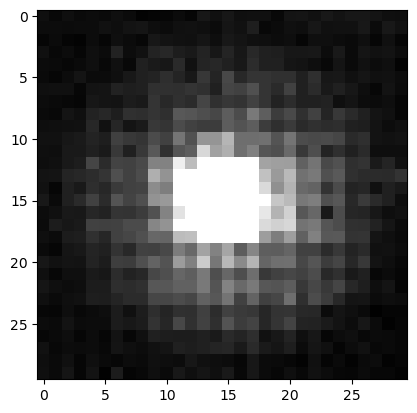

In [300]:
starList.displayStar(283, mode='zoom')

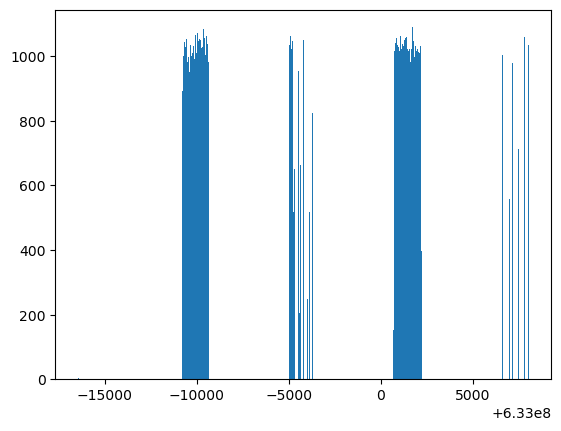

In [301]:
starData = getData(stars[283])
plt.hist(starData['TIME'], bins=1000)
plt.show()

In [338]:
r, mt = getSignals(5, starData['TIME'], False)

In [339]:
for i in range(len(r)):
    print(i, r[i], mt[i])

0 -3.3564142212504287 632989219
1 0.15797491232071667 632989220
2 0.49780540093461606 632989221
3 0.1328947992539674 632989222
4 0.058647761927328575 632989223
5 0.005150625096732536 632989224
6 -0.019461285745830295 632989225
7 -0.022178296268903556 632989226
8 -0.03683248664970374 632989227
9 -0.0641774167166455 632989228
10 -0.0831337039053298 632989229
11 -0.07117046804069363 632989230
12 -0.05878436387738381 632989231
13 0.0035174207168901647 632989232
14 0.03880757764316853 632989233
15 0.05817767511594312 632989234
16 0.049139765457830664 632989235
17 0.052639594809504656 632989236
18 0.029115269149988583 632989237
19 -0.028363229506317596 632989238
20 -0.08261119613522624 632989239
21 -0.07221155017238574 632989240
22 -0.07116117060645065 632989241
23 -0.08326474854042853 632989242
24 -0.0776982450353711 632989243
25 0.006923090871238674 632989244
26 0.05406623668492162 632989245
27 0.07790623105662581 632989246
28 0.05670549931867631 632989247
29 0.07920188386283251 632989248


amp 455.31852770602035 mean 0.004721558705278427 stdev 0.047279417199187226


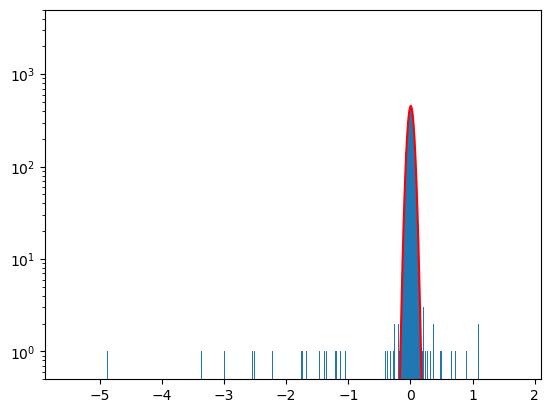

(-0.007316415031780654, 0.16424379065928882, 0.8139025382646634)

In [340]:
visualizeSignals(r, 400)

In [341]:
unusualSignalInfo(r, mt, 1, False)

index 1802 with ratio 1.0973305636891988 at time 632995877
index 1848 with ratio 1.1007338347255078 at time 632996117


window 5
amp 1712.841717209714 mean 0.019803614625553054 stdev -0.05087892986863163


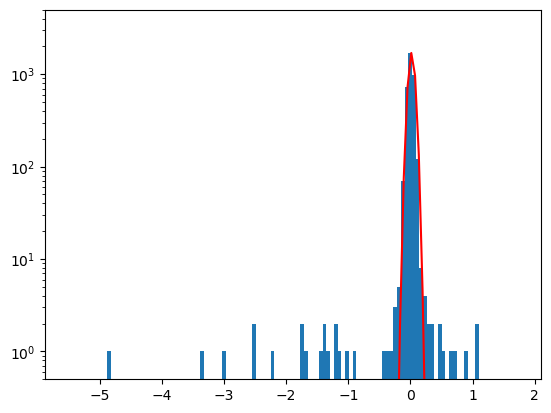

window 6
amp 1630.0006494239633 mean 0.01084427555268047 stdev 0.03249257356462549


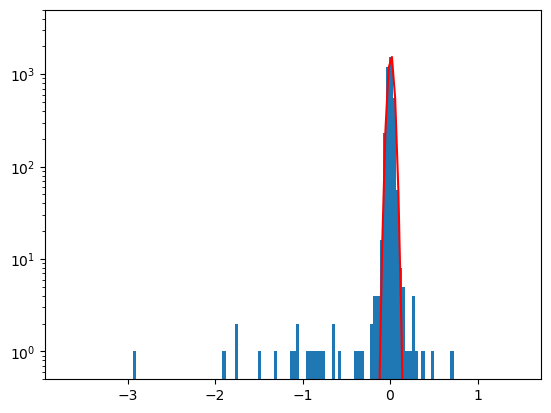

window 7
amp 1469.1155848122678 mean 0.007608047030333847 stdev -0.02195155978444316


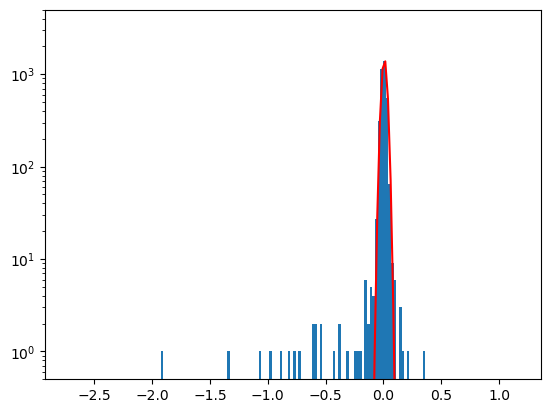

window 8
amp 674.5173289456836 mean 0.006420588113625684 stdev 0.016222103056376058


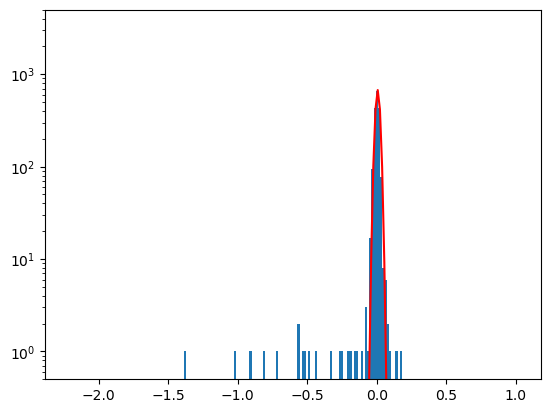

window 9
amp 765.1177153105474 mean 0.005797803241986842 stdev -0.011461186387138955


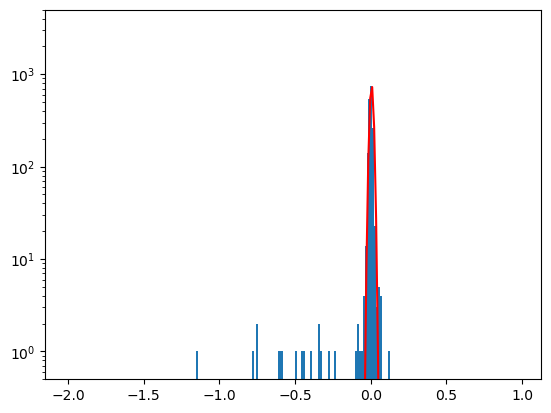

window 10
amp 744.263142723361 mean 0.00425305254924317 stdev 0.009262666525633484


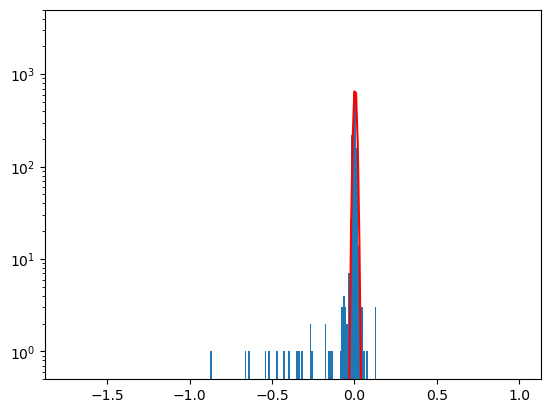

window 11
amp 752.9479510732207 mean 0.0037528505775809586 stdev 0.006923707289885541


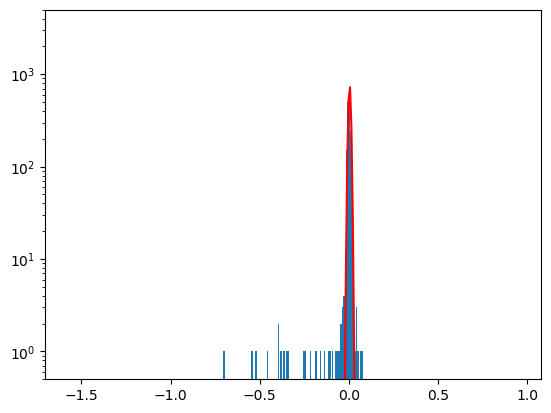

window 12
amp 479.8246257936112 mean 0.002836613622881229 stdev 0.0058928877582376015


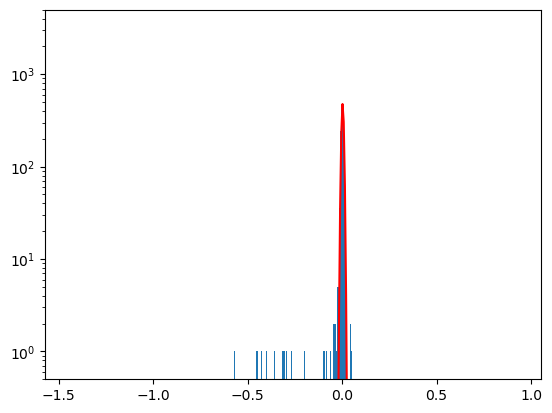

window 13
amp 442.4611374943557 mean 0.0021367702046655485 stdev -0.004839607424340802


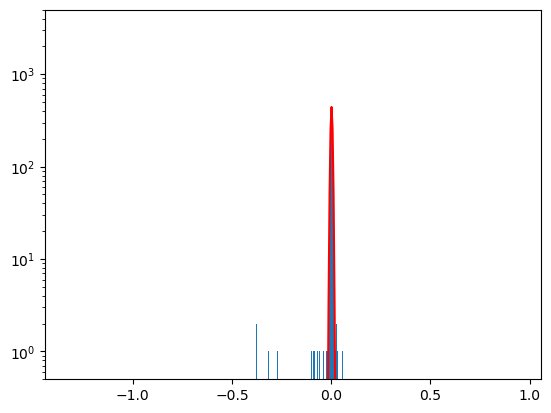

window 14
amp 424.40879899992314 mean 0.0017708911581297594 stdev -0.003959995460599741


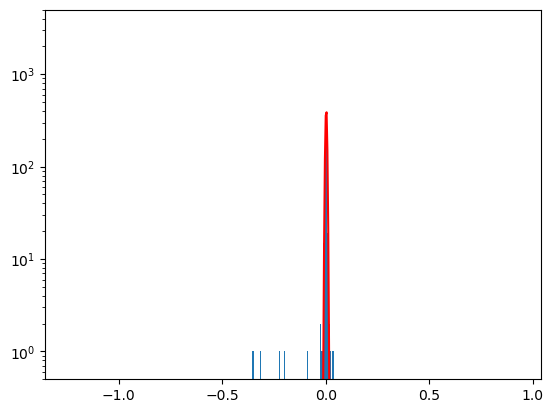

window 15
amp 419.47655783031996 mean 0.00138749033652484 stdev -0.0032651268531678655


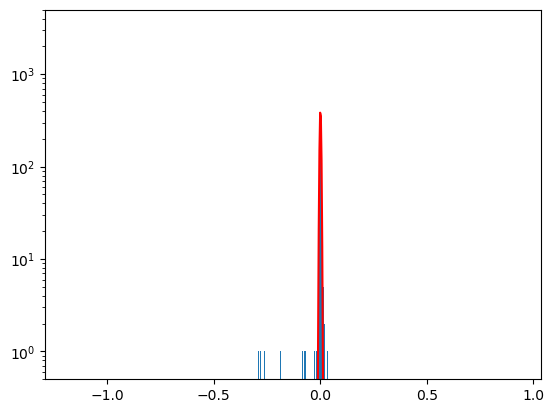

window 16
amp 295.2390695524805 mean 0.0011906619064424508 stdev 0.002806701263622577


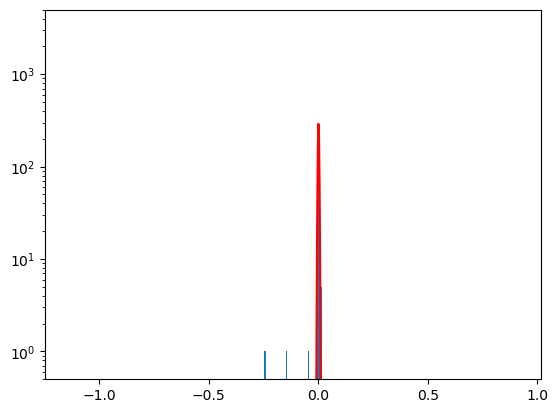

window 17
amp 336.24804688881784 mean 0.0009488985122525631 stdev 0.0023616455039977874


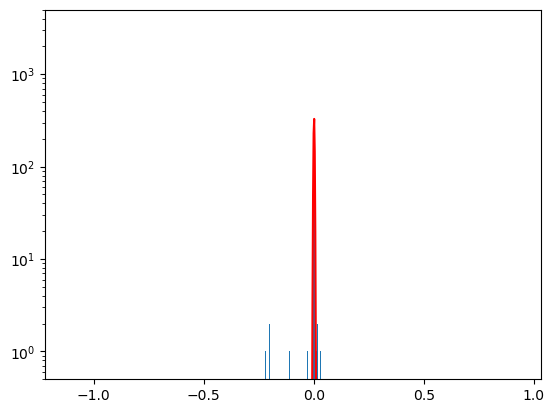

window 18
amp 326.9009281296016 mean 0.0007595698995112077 stdev 0.0020827539229823313


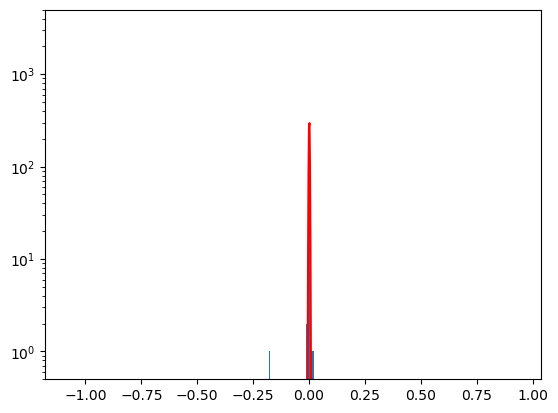

window 19
amp 314.9824866512484 mean 0.0006945797616854794 stdev 0.001908020499206567


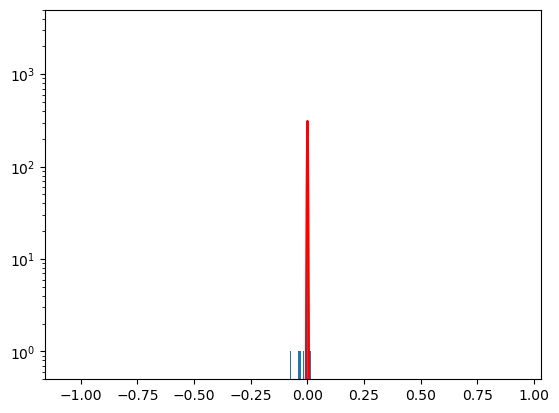

window 20
amp 247.4844456018417 mean 0.0006579154304275488 stdev 0.0016192277057818759


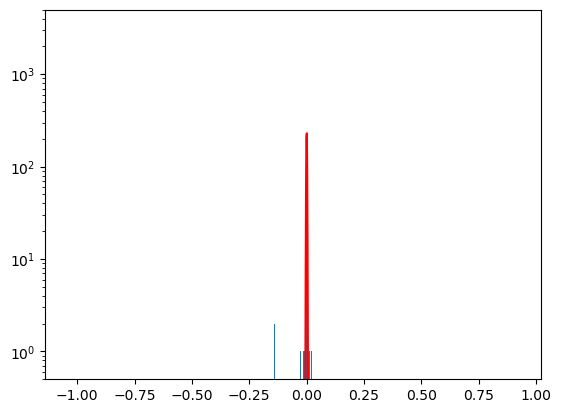

window 21
amp 250.26830035922137 mean 0.0005609282918690164 stdev 0.0015738548951267292


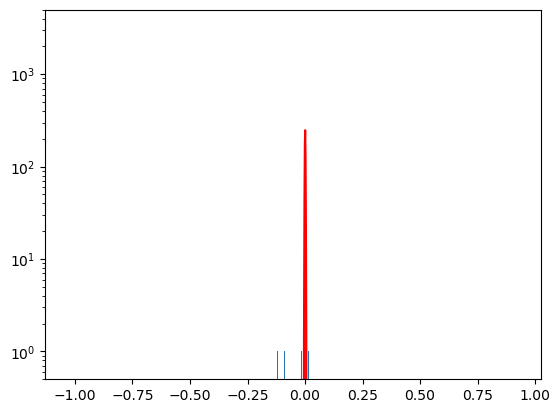

window 22
amp 245.84926654727778 mean 0.000520947557272365 stdev 0.0013165876207214826


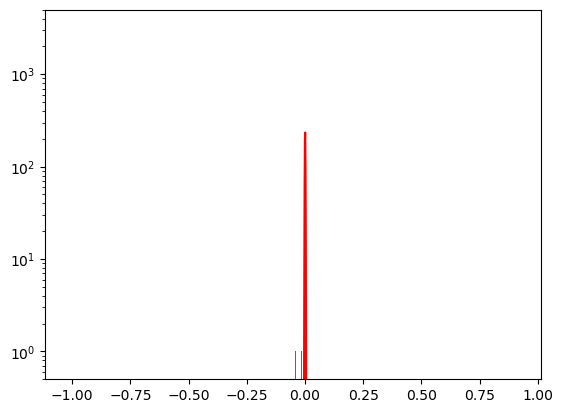

window 23
amp 234.22488234315688 mean 0.00047022777901831967 stdev 0.0011933691742774253


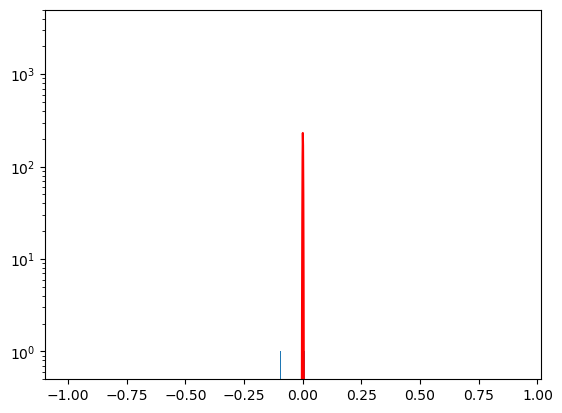

window 24
amp 208.5840980642371 mean 0.0003411857342405955 stdev -0.0010581512018993868


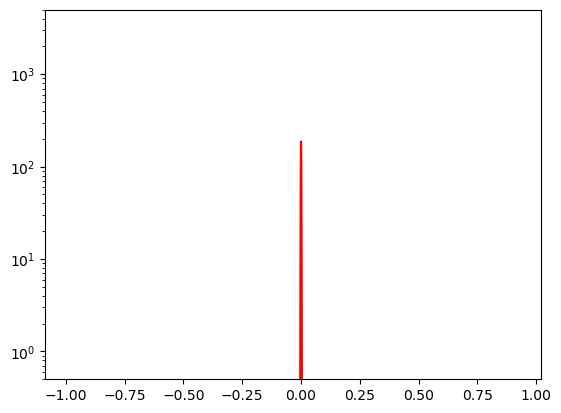

window 25
amp 190.32984943049942 mean 0.00039007527234286124 stdev 0.0010111863765554453


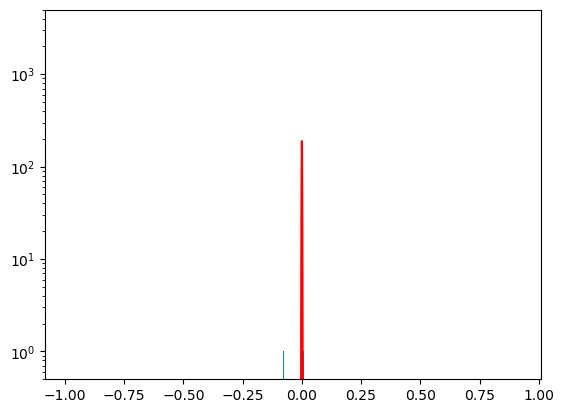

window 26
amp 187.8763972394629 mean 0.0003544866868024337 stdev 0.0009375881815613974


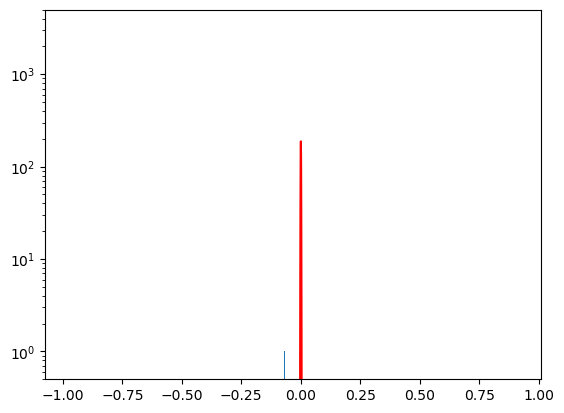

window 27
amp 192.31036472213816 mean 0.00027656167391669554 stdev 0.0008882934276125163


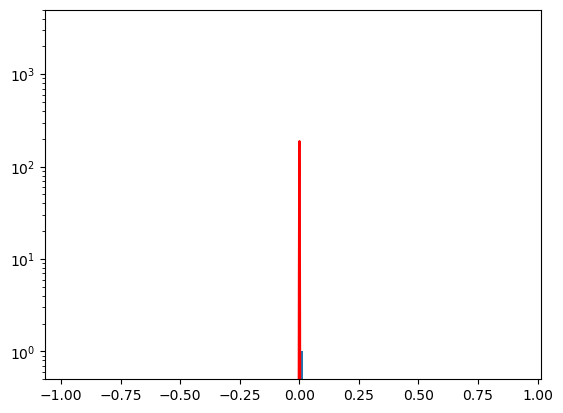

window 28
amp 162.2648399398525 mean 0.000272581192532083 stdev 0.0008101728415973092


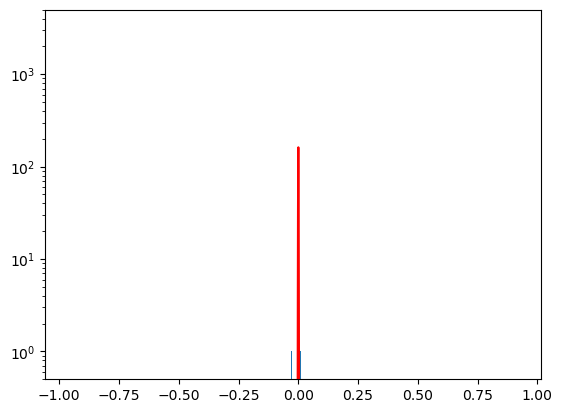

window 29
amp 166.15708641496016 mean 0.00027796000100397306 stdev 0.0007124397735182005


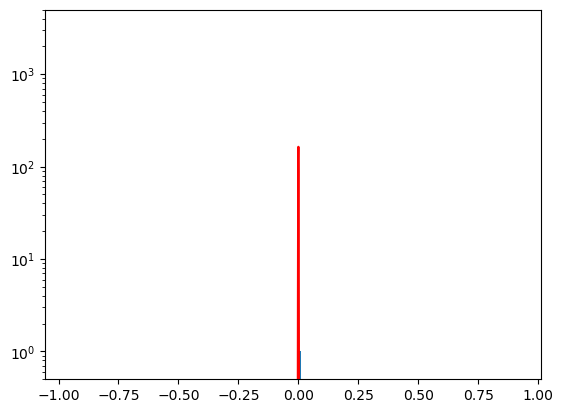

dict_keys([5, 6, 7])

In [337]:
analyzeStar(starData['TIME'])

In [342]:
print('ratio', calculateRatio(5, 632996117, np.array(sorted(starData['TIME'])), True))

signalCounts 228 signalArea 5
bgCounts 301 bgArea 7.5
bgMean 40.13333333333333 signal 5.466666666666669 totalNoise 4.55350011284227
snr 1.2005416780926363
ratio 1.2005416780926363


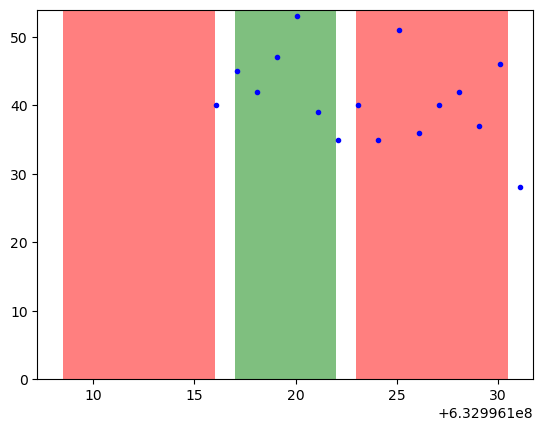

 time_bin_start time_bin_size num_events
                      s                 
--------------- ------------- ----------
632996116.08398           1.0         40
632996117.08398           1.0         45
632996118.08398           1.0         42
632996119.08398           1.0         47
632996120.08398           1.0         53
632996121.08398           1.0         39
            ...           ...        ...
632996125.08398           1.0         51
632996126.08398           1.0         36
632996127.08398           1.0         40
632996128.08398           1.0         42
632996129.08398           1.0         37
632996130.08398           1.0         46
632996131.08398           1.0         28
Length = 16 rows


In [344]:
print(visualizeStarTS(starData, binsize=1, windowSize=5, windowStart=632996117, point=True))

In [146]:
## Not very useful (for now)

# plt.hist(events_clean['TIME']-633000000, bins=1000)
# plt.axvline(x=7709, c='r')
# plt.xlim(6000, 8500)
# plt.show()